<a href="https://colab.research.google.com/github/LPValente/TensorFlow2.0/blob/main/TF2_0_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x # Only Colab
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [3]:
# More imports
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2023-06-18 03:40:58--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  99.9MB/s    in 1.9s    

2023-06-18 03:41:00 (99.9 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [6]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [7]:
!ls

ml-20m	ml-20m.zip  sample_data


In [9]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [10]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# currend_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [11]:
# Now do the same thing for movie ids
# currend_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#   global current_movie_id, custom_movie_map
#   old_movie_id = row['movieId']
#   if old_movie_id not in custom_movie_map:
#     custom_movie_map[old_movie_id] = current_movie_id
#     current_movie_id += 1
#   return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [12]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [13]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
K = 10

In [14]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embeddings
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
x = Dense(1)(x)


In [15]:
# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mse',
    optimizer=SGD(learning_rate=0.08, momentum=0.9),
)

In [16]:
# split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

In [17]:
# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [18]:
r = model.fit(
    x =[train_user, train_movie],
    y = train_ratings,
    epochs=25,
    batch_size=1024,
    verbose=2, # goes a little faster when you don't print the progress bar
    validation_data=([test_user, test_movie], test_ratings),
)

Epoch 1/25
15626/15626 - 246s - loss: 0.7656 - val_loss: 0.7162 - 246s/epoch - 16ms/step
Epoch 2/25
15626/15626 - 198s - loss: 0.6998 - val_loss: 0.6956 - 198s/epoch - 13ms/step
Epoch 3/25
15626/15626 - 203s - loss: 0.6786 - val_loss: 0.6823 - 203s/epoch - 13ms/step
Epoch 4/25
15626/15626 - 203s - loss: 0.6641 - val_loss: 0.6741 - 203s/epoch - 13ms/step
Epoch 5/25
15626/15626 - 194s - loss: 0.6540 - val_loss: 0.6720 - 194s/epoch - 12ms/step
Epoch 6/25
15626/15626 - 204s - loss: 0.6415 - val_loss: 0.6572 - 204s/epoch - 13ms/step
Epoch 7/25
15626/15626 - 191s - loss: 0.6257 - val_loss: 0.6482 - 191s/epoch - 12ms/step
Epoch 8/25
15626/15626 - 191s - loss: 0.6125 - val_loss: 0.6469 - 191s/epoch - 12ms/step
Epoch 9/25
15626/15626 - 203s - loss: 0.6025 - val_loss: 0.6397 - 203s/epoch - 13ms/step
Epoch 10/25
15626/15626 - 191s - loss: 0.5944 - val_loss: 0.6400 - 191s/epoch - 12ms/step
Epoch 11/25
15626/15626 - 204s - loss: 0.5870 - val_loss: 0.6350 - 204s/epoch - 13ms/step
Epoch 12/25
15626/1

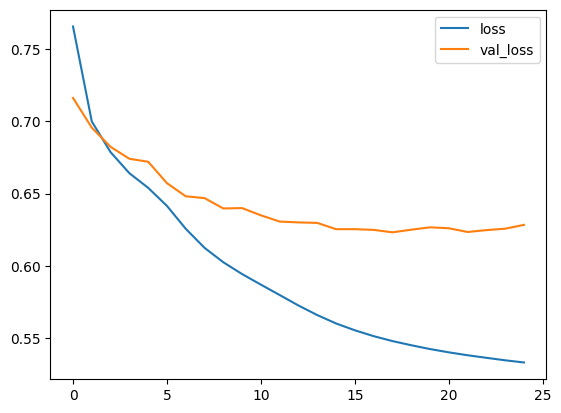

In [19]:
# plot losses
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [22]:
# is this on par with other approaches?
# https://datascience.stackexchange.com/questions/29740/benchmark-result-for-movielen
np.sqrt(r.history['val_loss'][-1])

0.7927059621353543